In [1]:
%matplotlib inline


Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.569s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.049s
Fitting the classifier to the training set
done in 47.604s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting the people names on the testing set
done in 0.113s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.94     

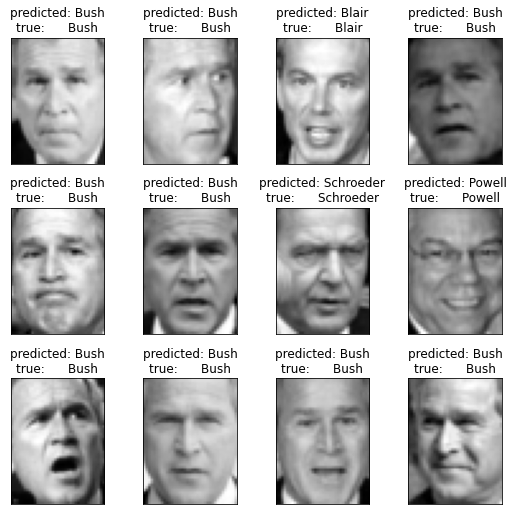

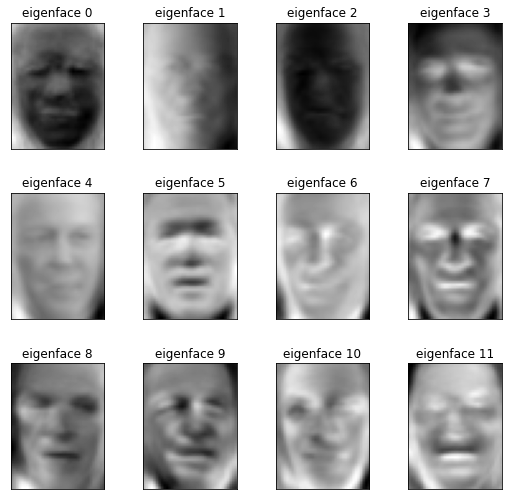

In [2]:
# %load eigenfaces.py
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

"""



print(__doc__)

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model(
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        try:
          pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
          pl.title(titles[i], size=12)
        except:
          pass
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


In [3]:
### PCA will order the principal components by maximal variance
### How much of the variance is explained by the first principal component? The second?
print(pca.explained_variance_ratio_[0:2])

[0.19334693 0.15120733]


Extracting the top 10 eigenfaces from 966 faces
done in 0.370s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.047s
Fitting the classifier to the training set
done in 250.618s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1)
Predicting the people names on the testing set, Number of Eigenfaces: 10
done in 0.049s
                   precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.44      0.52      0.47        60
  Donald Rumsfeld       0.27      0.37      0.31        27
    George W Bush       0.67      0.58      0.62       146
Gerhard Schroeder       0.18      0.20      0.19        25
      Hugo Chavez       0.30      0.20      0.24        15
       Tony Blair       0.50      0.39      0.44        36

         accuracy                           0.47       322
        macro avg       0.35      0.34      0.34       322
     weighted avg       0.50     

IndexError: index 10 is out of bounds for axis 0 with size 10

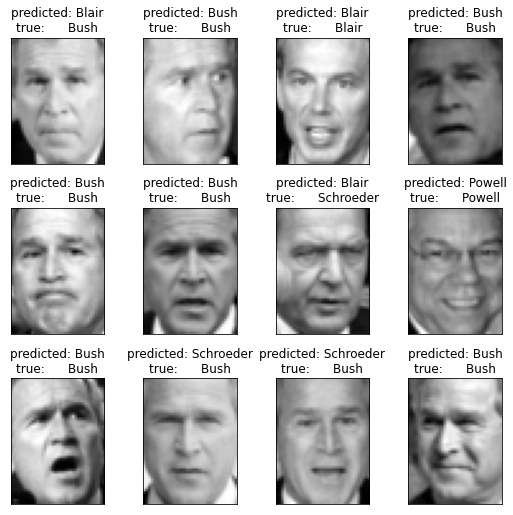

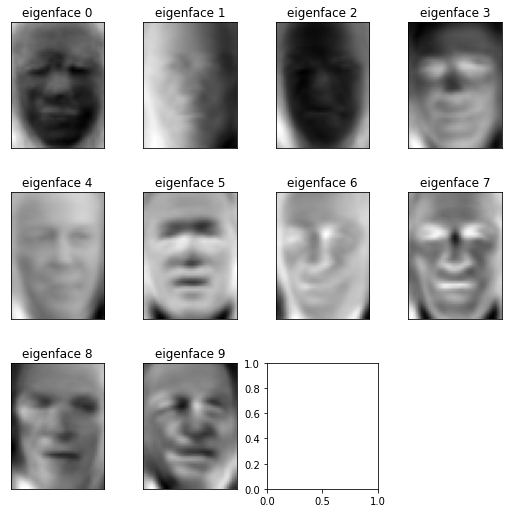

In [4]:
### Change n_components to the following values: [10, 15, 25, 50, 100, 250]. 
### For each number of principal components, note the F1 score for Ariel Sharon. 
### If you see a higher F1 score, does it mean the classifier is doing better, or worse?
n_components = [10, 15, 25, 50, 100, 250]

for n in n_components:
    print("Extracting the top %d eigenfaces from %d faces" % (n, X_train.shape[0]))
    t0 = time()
    pca_n = RandomizedPCA(n_components=n, whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca_n.components_.reshape((n, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca_n.transform(X_train)
    X_test_pca = pca_n.transform(X_test)
    print("done in %0.3fs" % (time() - t0))


    ###############################################################################
    # Train a SVM classification model(
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {
            'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
            }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf_n = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf_n = clf_n.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf_n.best_estimator_)


    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print("******************************")
    print("Predicting the people names on the testing set, Number of Eigenfaces: {}".format(n))
    t0 = time()
    y_pred = clf_n.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


    ###############################################################################
    # Qualitative evaluation of the predictions using matplotlib

    prediction_titles = [title(y_pred, y_test, target_names, i)
                            for i in range(y_pred.shape[0])]

    plot_gallery(X_test, prediction_titles, h, w)

    # plot the gallery of the most significative eigenfaces

    eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    plot_gallery(eigenfaces, eigenface_titles, h, w)

    pl.show()
